In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
reconstruction_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Sense/reconstructions/'
file = 'file_brain_AXFLAIR_209_6001340.h5'  # R = 4

GT_path = os.path.join(GT_path,file)
reconstruction_path = os.path.join(reconstruction_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction = h5py.File(reconstruction_path, 'r')


In [2]:
GT = GT['reconstruction_rss']
reconstruction = reconstruction['reconstruction']

GT = np.array(GT)
reconstruction = np.array(reconstruction)

def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]
reconstruction = comp_img(reconstruction,(reconstruction.shape[0],320,320))


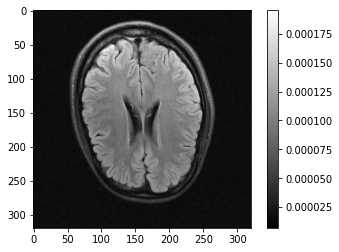

In [32]:
plt.imshow(GT[3], cmap='gray')
plt.colorbar()


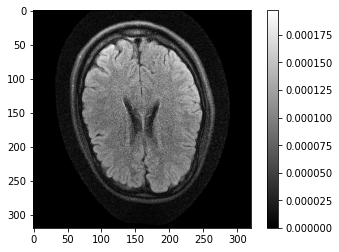

In [33]:
plt.imshow(reconstruction[3], cmap='gray')
plt.colorbar()


In [3]:
current_mean = reconstruction.mean()
print(current_mean)


2.6565725e-05


In [4]:
current_std = reconstruction.std()
print(current_std)


3.9327817e-05


In [5]:
def stacked_svd(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """
    Compute the average number of Singular Values required 
    to explain 90% of the variance in the residual error maps 
    of the reconstruction
    """
    residual_error_map = (gt-pred)**2
    U, S, Vh = np.linalg.svd(residual_error_map, full_matrices=True)
    num_slices = S.shape[0]
    im_size = S.shape[-1]
    singular_values_1d = S.flatten()
    abs_core = np.abs(singular_values_1d)
    sorted_indices = abs_core.argsort()[::-1]
    sorted_core = abs_core[sorted_indices]

    total_variance = np.sum(np.abs(sorted_core))

    # Calculate the cumulative sum of singular values
    cumulative_sum = np.cumsum(np.abs(sorted_core))

    num_svs = np.where(cumulative_sum >= 0.9*total_variance)[0][0] + 1

    num_svs_average = num_svs / num_slices

    return num_svs_average / im_size


How does the SVD metric change when adding (gaussian) noise at different levels?

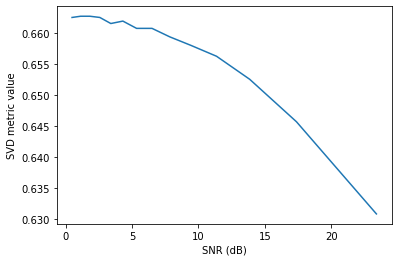

In [12]:
metric_list = []
SNR = []
for noise_factor in np.arange(0.1,2,0.1):
    noise = np.random.normal(loc=0, scale=noise_factor*current_mean, size=GT.shape)
    noise_std = noise.std()
    reconstruction_noise = reconstruction + noise
    metric_list.append(stacked_svd(GT, reconstruction_noise))
    snr = 10 * np.log10(current_std**2 / noise_std**2)
    SNR.append(snr)

SNR = np.array(SNR)
metric_array = np.array(metric_list)

SNR_mask = SNR >= 0

SNR_selected = SNR[SNR_mask]
metric_selected = metric_array[SNR_mask]

plt.plot(SNR_selected, metric_selected)
plt.ylabel('SVD metric value')
plt.xlabel('SNR (dB)')
plt.show()


In [ ]:
# This is how we want the metric to behave: the higher the std of the added Gaussian noise,
# the lesser the relative amount of structure in the residual error map (as the structure-less
# gaussian noise will dominate)

In [23]:
## Visual: No noise
stacked_svd(GT, reconstruction)


0.614453125

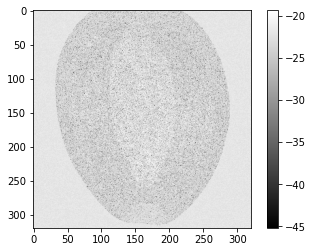

In [24]:
plt.imshow(np.log((GT[3]-reconstruction[3])**2), cmap='gray')
plt.colorbar()


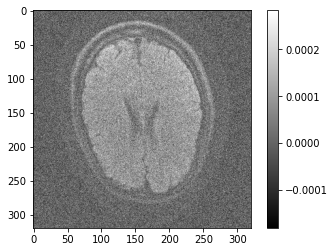

In [49]:
## Visual: Gaussian noise with mean = 0 and std = 1*current_std
noise = np.random.normal(loc=0, scale=1*current_std, size=GT.shape)
reconstruction_noise = reconstruction + noise

plt.imshow(reconstruction_noise[3], cmap='gray')
plt.colorbar()


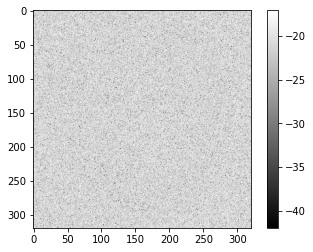

In [50]:
plt.imshow(np.log((GT[3]-reconstruction_noise[3])**2), cmap='gray')
plt.colorbar()


In [51]:
stacked_svd(GT, reconstruction_noise)


0.6626953125

How does the SVD metric behave for various amounts of structured errors?

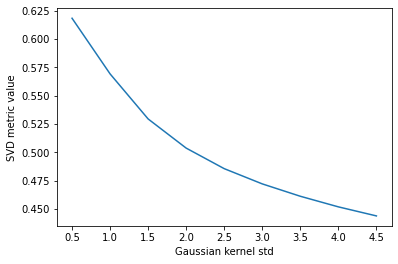

In [5]:
from scipy.ndimage import gaussian_filter

metric_list = []
kernel_stds = []
for kernel_std in np.arange(0.5,5,0.5):
    reconstruction_blurred = gaussian_filter(reconstruction,kernel_std)
    metric_list.append(stacked_svd(GT, reconstruction_blurred))
    kernel_stds.append(kernel_std)

plt.plot(kernel_stds, metric_list)
plt.ylabel('SVD metric value')
plt.xlabel('Gaussian kernel std')
plt.show()


In [ ]:
# This is how we want the metric to behave: the higher the std of the Gaussian kernel,
# the higher the relative amount of structure in the residual error map

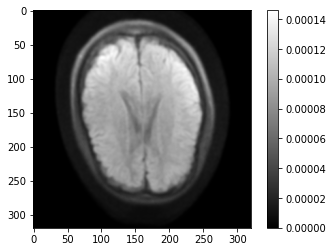

In [65]:
## Visual: Blurring with a Gaussian kernel with std = 1.5
reconstruction_blurred = gaussian_filter(reconstruction,1.5)

plt.imshow(reconstruction_blurred[3], cmap='gray')
plt.colorbar()

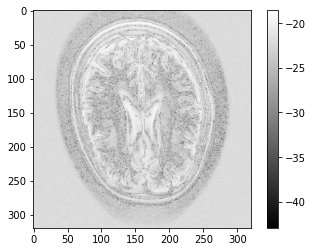

In [66]:
plt.imshow(np.log((GT[3]-reconstruction_blurred[3])**2), cmap='gray')
plt.colorbar()


In [68]:
stacked_svd(GT, reconstruction_blurred)


0.5294921875

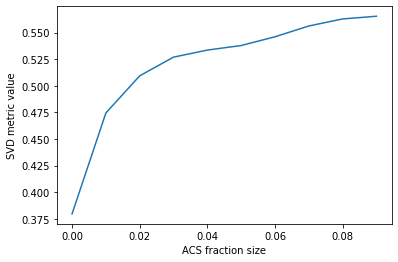

In [111]:
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

metric_list = []
ACS_fractions = []
for ACS_fraction in np.arange(0,0.1,0.01):
    kspace = np.fft.fft2(reconstruction)
    kspace = np.fft.fftshift(kspace)
    # GRAPPA type mask
    mask_func = EquispacedMaskFunc(center_fractions=[ACS_fraction], accelerations=[4])
    masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace)
    masked_kspace = np.fft.ifftshift(masked_kspace)
    reconstruction_undersampled = np.abs(np.fft.ifft2(masked_kspace))
    metric_list.append(stacked_svd(GT, reconstruction_undersampled))
    ACS_fractions.append(ACS_fraction)

plt.plot(ACS_fractions, metric_list)
plt.ylabel('SVD metric value')
plt.xlabel('ACS fraction size')
plt.show()


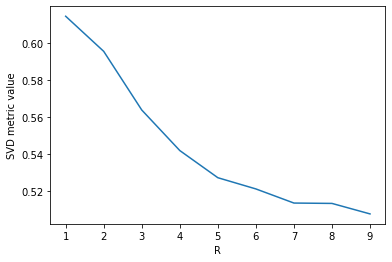

In [112]:
metric_list = []
R_list = []
for R in np.arange(1,10,1):
    kspace = np.fft.fft2(reconstruction)
    kspace = np.fft.fftshift(kspace)
    # GRAPPA type mask
    mask_func = EquispacedMaskFunc(center_fractions=[0.05], accelerations=[R])
    masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)
    masked_kspace = T.tensor_to_complex_np(masked_kspace)
    masked_kspace = np.fft.ifftshift(masked_kspace)
    reconstruction_undersampled = np.abs(np.fft.ifft2(masked_kspace))
    metric_list.append(stacked_svd(GT, reconstruction_undersampled))
    R_list.append(R)

plt.plot(R_list, metric_list)
plt.ylabel('SVD metric value')
plt.xlabel('R')
plt.show()


In [ ]:
# This is how we want the metric to behave: the higher the degree of undersampling,
# the higher the relative amount of structure in the residual error map

In [107]:
## Visual: Undersampling in k-space
kspace = np.fft.fft2(reconstruction)
kspace = np.fft.fftshift(kspace)

mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)
masked_kspace = T.tensor_to_complex_np(masked_kspace)

masked_kspace = np.fft.ifftshift(masked_kspace)
reconstruction_undersampled = np.abs(np.fft.ifft2(masked_kspace))


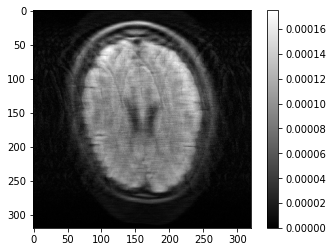

In [108]:
plt.imshow(reconstruction_undersampled[3], cmap='gray')
plt.colorbar()


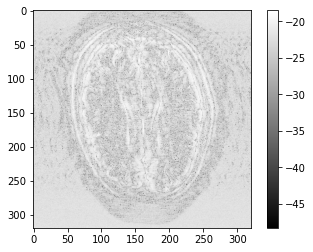

In [109]:
plt.imshow(np.log((GT[3]-reconstruction_undersampled[3])**2), cmap='gray')
plt.colorbar()
